# Rasterio

## Intro
Rasterio is the main library to work with raster data on python.
It has two levels of data structures:
- 1: Datasets: holds all the geospatial attributes such as crs (coordinate system), transform (affine), bounds and bands.
- 2: Arrays: numpy nd arrays

For this tutorial we will use CBERS-4a images. It can be downloaded on http://www2.dgi.inpe.br/catalogo/explore

## Main goals
- Merge RGB bands, clip and reproject CBERS images
- Plot the results and intermediate steps


## Summary
- [Open and read an image and metadata](#open-dataset)
- [Mosaic](#mosaic)
- [Clip](#clip)
- [Reproject](#reproject)
- [Plot](#plot)

## References
https://rasterio.readthedocs.io/en/stable/quickstart.html

# Setup

In [1]:
import rasterio as rio
import rasterio.warp as warp

from shapely.geometry import box
import geopandas as gpd

import numpy as np

from matplotlib import pyplot as plt
from rasterio.plot import show

In [2]:
with open('../data/raster/CBERS/inpe_catalog_2023_7_11_21_42_6.txt', 'r') as file:
    bands = file.read()
link_band1 = bands.split('\n')[2]
link_band2 = bands.split('\n')[4]
link_band3 = bands.split('\n')[6]

# Open Dataset
When you use rio.open(path) it creates a rasterio dataset without using system memory.
It simply loads the metadata (crs, pixel size, bounds, etc.).

In [3]:
# You need to be logged in on http://www2.dgi.inpe.br/catalogo/explore with your email
dataset = rio.open(link_band1)

# Dataset attributes

In [4]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': 0.0, 'width': 14160, 'height': 14537, 'count': 1, 'crs': CRS.from_epsg(32723), 'transform': Affine(8.0, 0.0, 333326.0,
       0.0, -8.0, 7511958.0), 'blockysize': 1, 'tiled': False, 'compress': 'deflate', 'interleave': 'band'}

In [5]:
dataset.mode

'r'

In [6]:
print(dataset.width)
print(dataset.height)

14160
14537


## Bands

In [7]:
dataset.count

1

In [8]:
dataset.indexes

(1,)

In [9]:
# show the dtype for each bands
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'int16'}

# Read 
When you use the read function it returns a numpy array.
The data is loaded to memory.

In [11]:
band1 = dataset.read(1)

In [ ]:
type(band1)

numpy.ndarray

In [ ]:
band1.shape

## Coordinate system

In [ ]:
dataset.crs

CRS.from_epsg(32723)

## Transform Affine
The affine transform describes the relationship between raster position to georeferenced coordinates. 

It is used to translate (geotransform) a matrix to an map.The affine transform consists of six coefficients

- a = width of a pixel
- b = row rotation (typically zero)
- c = x -coordinate of the upper-left corner of the upper-left pixel
- d = column rotation (typically zero)
- e = height of a pixel (typically negative)
- f = y -coordinate of the of the upper-left corner of the upper-left pixel

The six coefficients (a, b, c, d, e, f) define the pixel scale, rotation, and the position of the origin of the raster.

- Coefficients a and e: These represent the pixel scale and are usually the dimensions of a pixel in the units of the coordinate reference system (CRS).
- Coefficients b and d: These represent rotation. For north-up images, these are typically zero, as the image doesn't need to be rotated.
- Coefficients c and f: These represent the x and y coordinates (respectively) of the upper-left corner of the upper-left pixel, which is the origin of the raster.

**This transformation is crucial for ensuring that your raster data aligns correctly with other geospatial data.**

In [ ]:
dataset.transform

Affine(8.0, 0.0, 333326.0,
       0.0, -8.0, 7511958.0)

# Spatial indexes

In [ ]:
# Datasets have an index() method for getting the array indices corresponding to points in georeferenced space.
# To get the value for the pixel 100 kilometers east and 50 kilometers south of the dataset’s upper left corner,
# do the following.

x, y = (dataset.bounds.left + 1000, dataset.bounds.top - 500)
row, col = dataset.index(x, y)
row, col
band1[row, col]

0

In [ ]:
# To get the spatial coordinates of a pixel, use the dataset’s xy() method.
# The coordinates of the center of the image can be computed like this.

dataset.xy(dataset.height // 2, dataset.width // 2)

(389970.0, 7453810.0)

# Mosaic
## Merge bands into rgb image

### Directly from memory

In [7]:
# rescale image intensity before plotting.
def normalize(band):
    band_min, band_max = (np.nanmin(band), np.nanmax(band))
    return ((band - band_min))/((band_max - band_min))

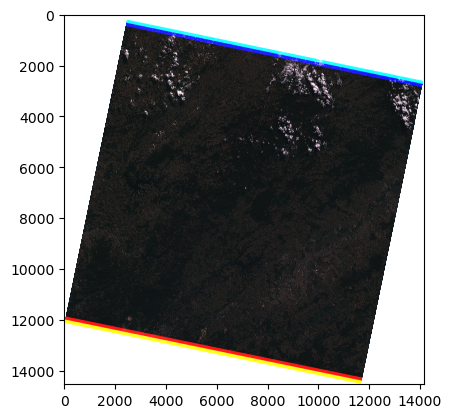

In [8]:
bands=[]
for b in [link_band1,link_band2,link_band3]:
    with rio.open(b) as file:
        img=file.read(1)
        img[img == img[0,0]] = np.nanmax(img) + 1
        bands.append((normalize(img)))

true_color = np.dstack([bands[2], bands[1], bands[0]]) # === true_color = np.stack([bands[2], bands[1], bands[0]], axis=2)
#true_color = true_color / true_color.max() # standardize

plt.imshow(true_color)

### Saving to a new file

In [9]:
band1=rio.open(link_band1)
band2=rio.open(link_band2)
band3=rio.open(link_band3)

In [10]:

band2_geo = band2.profile
band2_geo.update({"count": 3})

with rio.open('../data/raster/CBERS/rgb.tiff', 'w', **band2_geo) as dest:
    dest.write(band1.read(1),3) #red band
    dest.write(band2.read(1),2) #green
    dest.write(band3.read(1),1) #blue

In [109]:
# from rasterio.merge import merge
# merge(datasets=[rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND3.tif'),
#                 rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND2.tif'),
#                  rio.open('../data/raster/CBERS/CBERS_4A_WPM_20230412_204_143_L2_BAND1.tif')],
#         nodata=0)

# Clip

## Bounding box

In [11]:
# bounding box
dataset.bounds

BoundingBox(left=333326.0, bottom=7395662.0, right=446606.0, top=7511958.0)

In [10]:
#coordinates obtained by drawing on inpe platform: http://www2.dgi.inpe.br/catalogo/explore
bounding_box = box(-46.084089277,
                   -23.411604505,
                    -45.780097007,-23.173697511)

In [11]:
# Save the boundbox as a shapefile can be usefull

# geom = box(*bounds)
# # Create a shapefile with GeoPandas

# df = gpd.GeoDataFrame({"id":1,"geometry":[geom]})
# df = df.set_crs(dataset.crs)
# df=df.to_crs('4326')
# df.to_file("..data/tmp/cbers_boundary.shp")

# In one line:

df = gpd.GeoDataFrame({"id":1,"geometry":[bounding_box]},crs='4326')
df.to_file("../data/tmp/cbers_boundary.shp")

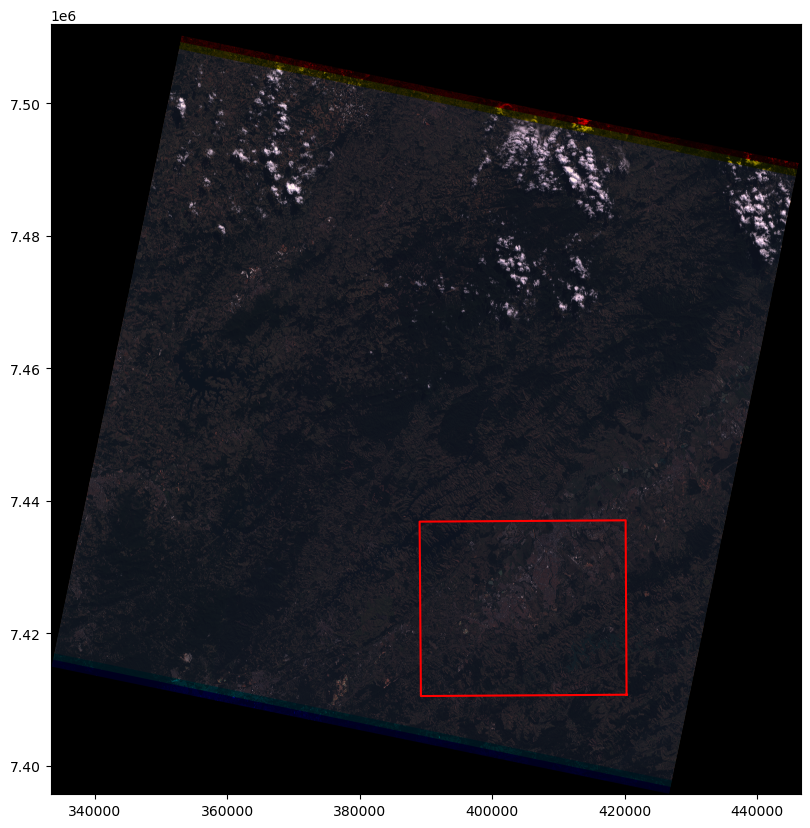

In [12]:
inshp = "../data/tmp/cbers_boundary.shp"
img_rgb_dataset = rio.open('../data/raster/CBERS/rgb.tiff')
Vector=gpd.read_file(inshp).to_crs(img_rgb_dataset.crs)
fig, ax = plt.subplots(1,1,figsize=(10,10))

show((img_rgb_dataset, [1,2,3]), adjust=True, ax = ax)
ax=plt.plot(*Vector.geometry[0].exterior.xy, color='r')

In [13]:
from rasterio.mask import mask
import geopandas as gpd

inshp = "../data/tmp/cbers_boundary.shp"
inRas = '../data/raster/CBERS/rgb.tiff'
outRas = '../data/raster/CBERS/rgb_clip.tiff'

Vector=gpd.read_file(inshp)

with rio.open(inRas) as src:
    Vector=Vector.to_crs(src.crs)
    # print(Vector.crs)
    out_image, out_transform=mask(src,Vector.geometry,crop=True)
    out_meta=src.meta.copy() # copy the metadata of the source DEM
    
out_meta.update({
    "driver":"Gtiff",
    "height":out_image.shape[1], # height starts with shape[1]
    "width":out_image.shape[2], # width starts with shape[2]
    "transform":out_transform
})
              
with rio.open(outRas,'w',**out_meta) as dst:
    dst.write(out_image)

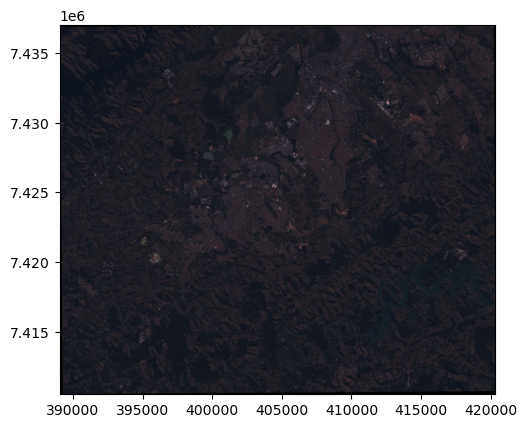

<Axes: >

In [15]:
img = rio.open('../data/raster/CBERS/rgb_clip.tiff')
show((img, [1,2,3]),adjust='linear')

# Reproject
---
Geographic coordinate systems

- EPSG: 4674 = SIRGAS 2000
- EPSG: 4326 = WGS 84

Projected coordinate systems
- EPSG:32723 - WGS 84 / UTM zone 23S
- EPSG:31983 - SIRGAS 2000 / UTM zone 23S
---





1 - Single band (bands of datasets on disk):
- Requires coordinate reference systems and transforms


In [16]:
# reproject from WGS 84 / UTM zone 23S 
# to SIRGAS 2000 / UTM zone 23S

warp.reproject(source=rio.band(dataset, 1),
               dst_crs= rio.crs.CRS.from_epsg(31983))

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16),
 Affine(7.999999999903662, 0.0, 333325.99999956356,
        0.0, -7.999999999903662, 7511958.000075955))

In [17]:
# reproject from WGS 84 / UTM zone 23S 
# to SIRGAS 2000 

warp.reproject(source=rio.band(dataset, 1),
                dst_crs= rio.crs.CRS.from_epsg(4674), # dataset.profile['crs'], #dataset.crs ,#rio.crs.CRS({'init':'EPSG:4326'}), 
               )

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=int16),
 Affine(7.509689863043608e-05, 0.0, -46.63280724819171,
        0.0, -7.509689863043608e-05, -22.490683316675963))

2 - Source and destination are ndarrays:
- Pass coordinate reference system definitions and affine transformation parameters 
or ground control points (gcps) are required for reprojection.

In [18]:
from rasterio.warp import reproject
from rasterio.warp import calculate_default_transform, reproject, Resampling

src_dataset = rio.open('../data/raster/CBERS/rgb_clip.tiff')
dst_crs = rio.crs.CRS.from_epsg(4326)
         # OR dataset.profile['crs'], # OR dataset.crs ,# OR rio.crs.CRS({'init':'EPSG:4326'}), 

# transform, width, height = calculate_default_transform(
#         src_dataset.crs, dst_crs, src_dataset.width, src_dataset.height, *src_dataset.bounds)

# out = np.ones((width,height), dtype=np.uint8)

out_raster, out_transform =  warp.reproject(source=src_dataset.read(),
                                                src_crs = src_dataset.crs,
                                                dst_crs= dst_crs ,
                                                src_transform=src_dataset.transform,
                                                src_nodata=0,
                                                dst_nodata = -9999
                                                # dst_transform=transform
                                                )

3 - To save as a new tif file:

In [19]:
#https://hatarilabs.com/ih-en/how-to-reproject-single-and-multiple-rasters-with-python-and-rasterio-tutorial
from rasterio.warp import calculate_default_transform, reproject, Resampling
#open source raster
srcRst = img
dstCrs = {'init': 'EPSG:4326'}

#calculate transform array and shape of reprojected raster
transform, width, height = warp.calculate_default_transform(
        srcRst.crs, dstCrs, srcRst.width, srcRst.height, *srcRst.bounds)

kwargs = srcRst.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height
    })
#open destination raster
dstRst = rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'w', **kwargs)
#reproject and save raster band data
for i in range(1, srcRst.count + 1):
    warp.reproject(
        source=rio.band(srcRst, i),
        destination=rio.band(dstRst, i),
        #src_transform=srcRst.transform,
        src_crs=srcRst.crs,
        #dst_transform=transform,
        dst_crs=dstCrs,
        resampling=warp.Resampling.nearest)
#close destination raster
dstRst.close()

# No data
Sometimes the no data values are not defined in the image file, so it is needed to explicit declare with values represents null values.

We can also change the no data value using numpy.where() function

In [68]:
np.where(out_raster[0]==-9999,None,out_raster[0])

array([[None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [ ]:
np.where(out_raster == -9999)

(array([0, 0, 0, ..., 2, 2, 2], dtype=int64),
 array([  0,   0,   0, ..., 281, 281, 281], dtype=int64),
 array([  0,   1,   2, ..., 325, 326, 327], dtype=int64))

In [83]:
# https://rasterio.groups.io/g/main/topic/change_the_nodata_value_in_a/28801885
# convert 0 to nodata
# You need to open the source file to read data values and metadata,
# then read the band data as numpy array,
# make the required changes to the numpy array and then save numpay array to a new dataset file:

def fix_no_data_value(input_file, output_file, actual_nodata_value=0, new_nodata_value=-9999):
    with rio.open(input_file, "r+") as src:
        src.nodata = actual_nodata_value
        with rio.open(output_file, 'w',  **src.profile) as dst:
            for i in range(1, src.count + 1):
                band = src.read(i)
                band = np.where(band==actual_nodata_value,new_nodata_value,band)
                dst.write(band,i)

# # usage example 
# input_file = "input_image.tif"
# output_file = "output.tif"
# no_data_value=0
# fix_no_data_value(input_file, output_file,no_data_value   )

In [84]:
src_dataset.crs


CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown_based_on_GRS80_ellipsoid",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",-12],PARAMETER["longitude_of_center",-54],PARAMETER["standard_parallel_1",-2],PARAMETER["standard_parallel_2",-22],PARAMETER["false_easting",5000000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [86]:
fix_no_data_value('../data/raster/CBERS/rgb_clip.tiff','../data/raster/CBERS/rgb_clip_nodata.tiff',-9999,200)

# Plot

In [16]:
# https://rasterio.readthedocs.io/en/latest/topics/color.html
# GDAL builds the color interpretation based on the driver and creation options. With the GTiff driver, rasters with exactly 3 bands of uint8 type will be RGB, 4 bands of uint8 will be RGBA by default.

# Color interpretation can be set when creating a new datasource with the photometric creation option:

# profile = src.profile
# profile['photometric'] = "RGB"
# with rio.open("/tmp/rgb.tif", 'w', **profile) as dst:
#     dst.write(src.read())

# # or via the colorinterp property when a datasource is opened in update mode:

# from rasterio.enums import ColorInterp
# with rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'r+', **profile) as src:
#     src.colorinterp = [
#         ColorInterp.red, ColorInterp.green, ColorInterp.blue]

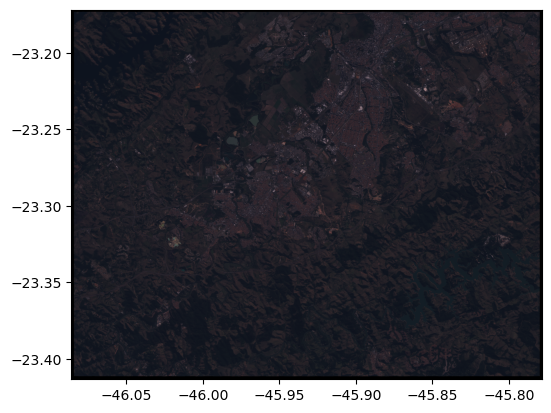

<Axes: >

In [21]:
img = rio.open('../data/raster/CBERS/rgb_clip_wgs84.tiff', 'r')
show((img,[1,2,3]), adjust=True)

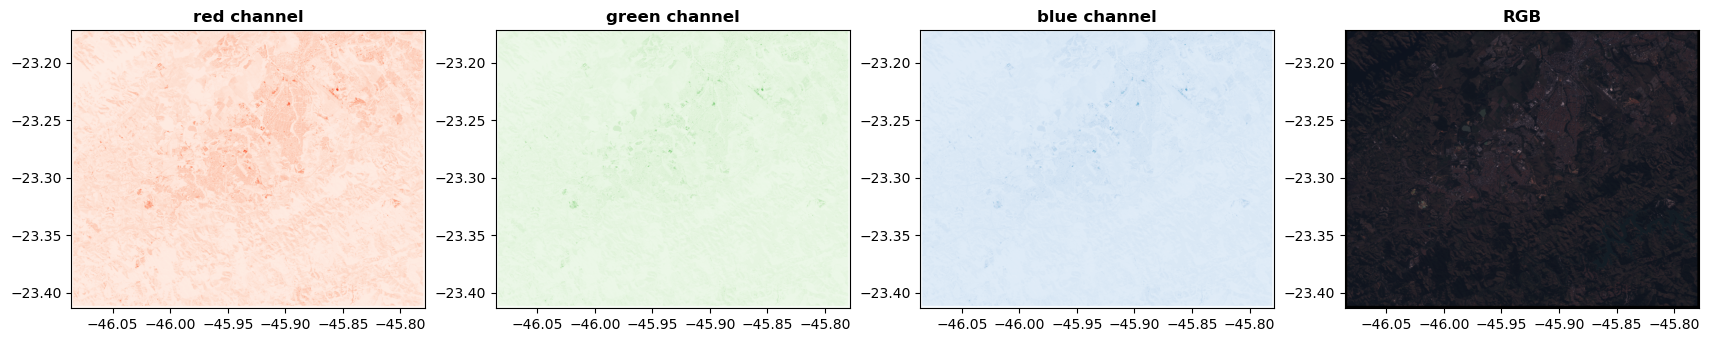

In [24]:
fig, (axr, axg, axb,axrgb) = plt.subplots(1,4, figsize=(21,10))
show((img, 1), ax=axr, cmap='Reds', title='red channel')
show((img, 2), ax=axg, cmap='Greens', title='green channel')
show((img, 3), ax=axb, cmap='Blues', title='blue channel')
show((img,[1,2,3]), ax=axrgb, title='RGB',adjust=True)

plt.show()

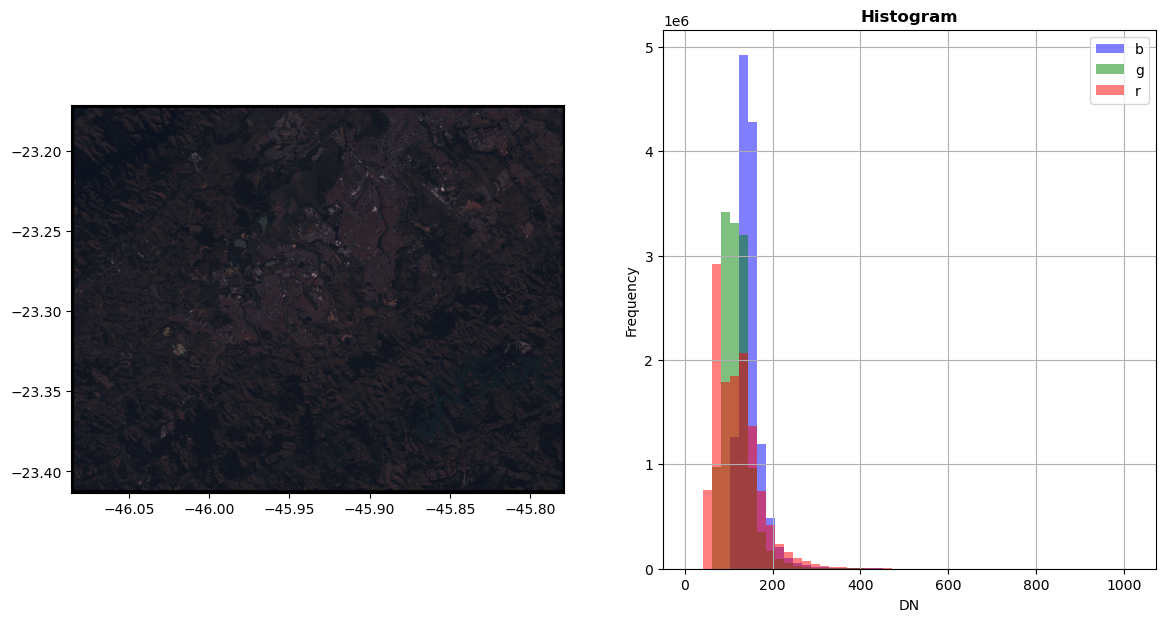

In [26]:
from rasterio.plot import show_hist
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show((img,[1,2,3]), ax=axrgb, adjust=True)
show_hist((img,[1,2,3]), bins=50, histtype='stepfilled',
          lw=0.0, stacked=False, alpha=0.5, ax=axhist,label=['r','g', 'b'])
plt.show()